# Training and Deploying ML Models using JAX on SageMaker
Amazon SageMaker provides you the flexibility to train models using any framework that can work in a Docker container. In this example we'll show how to utilize the bring your own container paradigm to train machine learning models using the increasingly popular [JAX library from Google](https://github.com/google/jax). We'll train a fashion mnist classification model using vanilla JAX and another model using the [higher level Trax library from Google](https://github.com/google/trax).

For both of these demos, we'll show how both JAX and Trax can serialize models using the TensorFlow standard [SavedModel format](https://www.tensorflow.org/guide/saved_model). This enables us to train these models in a custom container, but then deploy them using the managed and optimized SageMaker TensorFlow inference containers.


In [1]:
import os
import json

import boto3
import sagemaker
from sagemaker import get_execution_role

from sagemaker_jax import JaxEstimator

client = boto3.client("sts")
account = client.get_caller_identity()["Account"]
role = get_execution_role()
my_session = boto3.session.Session()
region = my_session.region_name

container_name = "sagemaker-jax"
ecr_image = "{}.dkr.ecr.{}.amazonaws.com/{}".format(account, region, container_name)

## Custom Framework Estimator
Since we'll be saving our JAX and Trax models as SavedModel format, we can create a subclass of the base [SageMaker Framework estimator](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html?highlight=Framework#sagemaker.estimator.Framework). This will enable us to specify a custom `create_model` method which leverages the existing TensorFlowModel class to launch inference containers

In [2]:
!pygmentize sagemaker_jax.py

# Copyright 2021 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.
"""
Custom Framework Estimator for JAX
"""
from sagemaker.estimator import Framework
from sagemaker.tensorflow.model import TensorFlowModel
from sagemaker.vpc_utils import VPC_CONFIG_DEFAULT


class JaxEstimator(Framework):
    def __init__(
        self, entry_point, source_dir=None, hyperparameters=None, image_uri=None, **kwargs
    ):
        super(JaxEstimator, self).__init__(
            entry_point, source_dir, hyperparameter

## Training Docker Container
Our custom training container is straight forward, though there are a few things worth mentioning that can be seen in the comments

In [3]:
!cat docker/Dockerfile

# Copyright 2021 Amazon.com, Inc. or its affiliates. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License"). You
# may not use this file except in compliance with the License. A copy of
# the License is located at
#
#     http://aws.amazon.com/apache2.0/
#
# or in the "license" file accompanying this file. This file is
# distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF
# ANY KIND, either express or implied. See the License for the specific
# language governing permissions and limitations under the License.

# Dockerfile for training models using JAX
# We build from NVIDIA container so that CUDA is available for GPU acceleration should the AWS instance support it
FROM nvidia/cuda:11.1-cudnn8-devel-ubuntu18.04

# Install python3
RUN apt update && apt install -y python3-pip

RUN ln -sf /usr/bin/python3 /usr/bin/python && \
    ln -sf /usr/bin/pip3 /usr/bin/pip

RUN pip --no-cache-dir install --upgrade pip setuptools_rust

# Install JAX 

## Building and Publishing the Image
The below shell script must only be ran if the docker image has not already been pushed to the Elastic Container Registry. 

**NOTE: Since SageMaker studio is already running inside of a Docker container, this script cannot be ran inside of SageMaker Studio. Please push your container using awscli or use this toolkit: https://github.com/aws-samples/sagemaker-studio-image-build-cli**

In [4]:
%%sh

container_name=sagemaker-jax
account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-west-2}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${container_name}"

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${container_name}" > /dev/null 2>&1
if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${container_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.
docker build  -t ${container_name} docker/
docker tag ${container_name} ${fullname}

docker push ${fullname}

## Serializing models as SavedModel format
In the upcoming training jobs we'll be training a vanilla JAX model and a Trax model on the [fashion mnist dataset](https://github.com/zalandoresearch/fashion-mnist). The full details of the model can be seen in the `training_scripts/` directory, but it is worth calling out the methods for serialization. 

The JAX model utilizes the new experimental jax2tf converter: https://github.com/google/jax/tree/master/jax/experimental/jax2tf

The Trax model utilizes the new trax2keras functionality: https://github.com/google/trax/blob/master/trax/trax2keras.py

## Train using Vanilla JAX

In [5]:
vanilla_jax_estimator = JaxEstimator(
    image_uri=ecr_image,
    role=role,
    instance_count=1,
    base_job_name=container_name + "-jax",
    source_dir="training_scripts",
    entry_point="train_jax.py",
    instance_type="ml.p2.xlarge",
    hyperparameters={"num_epochs": 3},
)
vanilla_jax_estimator.fit(logs=False)


2021-05-19 01:33:33 Starting - Starting the training job
2021-05-19 01:33:34 Starting - Launching requested ML instances.................
2021-05-19 01:35:04 Starting - Preparing the instances for training...............
2021-05-19 01:36:26 Downloading - Downloading input data
2021-05-19 01:36:33 Training - Downloading the training image..................................................................
2021-05-19 01:42:10 Training - Training image download completed. Training in progress....................
2021-05-19 01:43:48 Uploading - Uploading generated training model
2021-05-19 01:43:56 Completed - Training job completed


## Train Using JAX Medium-level API STAX

In [ ]:
stax_estimator = JaxEstimator(
    image_uri=ecr_image,
    role=role,
    instance_count=1,
    base_job_name=container_name + "-jax",
    source_dir="training_scripts",
    entry_point="train_stax.py",
    instance_type="ml.p2.xlarge",
    hyperparameters={"num_epochs": 3},
)

stax_estimator.fit(logs=False)


2021-05-19 01:51:31 Starting - Starting the training job
2021-05-19 01:51:33 Starting - Launching requested ML instances.............
2021-05-19 01:52:44 Starting - Preparing the instances for training.................
2021-05-19 01:54:16 Downloading - Downloading input data
2021-05-19 01:54:21 Training - Downloading the training image.........................

## Train Using JAX High-level API Trax

In [ ]:
trax_estimator = JaxEstimator(
    image_uri=ecr_image,
    role=role,
    instance_count=1,
    base_job_name=container_name + "-trax",
    source_dir="training_scripts",
    entry_point="train_trax.py",
    instance_type="ml.p2.xlarge",
    hyperparameters={"train_steps": 1000},
)

trax_estimator.fit(logs=False)


2021-05-19 03:18:13 Starting - Starting the training job
2021-05-19 03:18:15 Starting - Launching requested ML instances.............
2021-05-19 03:19:26 Starting - Preparing the instances for training...................
2021-05-19 03:21:05 Downloading - Downloading input data
2021-05-19 03:21:12 Training - Downloading the training image......................................................................
2021-05-19 03:27:09 Training - Training image download completed. Training in progress...........

## Deploy Both Models to prebuilt TF Containers
Since we've our customer Framework Estimator knows the models are to be served using TensorFlowModel, deploying these endpoints is just a trivial call to the `estimator.deploy()` method

In [6]:
vanilla_jax_predictor = vanilla_jax_estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


---------------!

In [ ]:
trax_predictor = trax_estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

In [ ]:
stax_predictor = stax_estimator.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

## Test Inference Endpoints
This requires TF to be installed on your notebook's kernel as it is used to load testing data

In [7]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [8]:
def test_image(predictor, test_images, test_labels, image_number):
    np_img = np.expand_dims(np.expand_dims(test_images[image_number], axis=-1), axis=0)

    result = predictor.predict(np_img)
    pred_y = np.argmax(result["predictions"])

    print("True Label:", test_labels[image_number])
    print("Predicted Label:", pred_y)
    plt.imshow(test_images[image_number])

True Label: 9
Predicted Label: 9


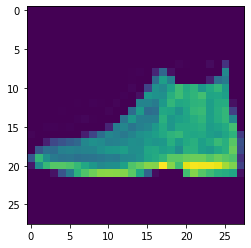

In [17]:
test_image(trax_predictor, x_test, y_test, 0)

True Label: 9
Predicted Label: 9


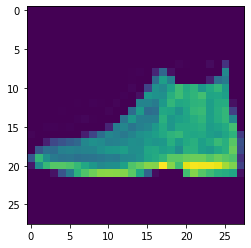

In [13]:
test_image(stax_predictor, x_test, y_test, 0)

True Label: 9
Predicted Label: 9


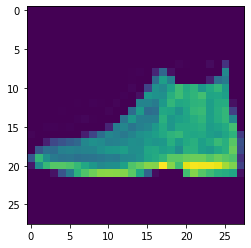

In [9]:
test_image(vanilla_jax_predictor, x_test, y_test, 0)

## Optional: Delete the running endpoints

In [18]:
# Clean-Up
vanilla_jax_predictor.delete_endpoint()
stax_predictor.delete_endpoint()
trax_predictor.delete_endpoint()